In [186]:
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import statistics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image

In [646]:
df = pd.read_csv("mls23full.csv")
#columns = ['Cmp', 'Att', 'TotDist', 'PrgDist', 'Cmp.1', 'Att.1',
#       'Cmp.2', 'Att.2', 'Cmp.3', 'Att.3', 'Ast', 'xAG',
#       'xA', 'A-xAG', 'KP', '1/3', 'PPA', 'CrsPA', 'PrgP']
columns = df.columns
# Set all columns to per 90 minutes
for col in columns:
    df[col] = pd.to_numeric(df[col], errors = "ignore")
#    df[col] = df[col]/df["90s"] 
#df = df.dropna(subset=['Pos', 'Matches', "Matches.9"]).reset_index(drop=True)
df = df.dropna(subset=['Pos']).reset_index(drop=True)
df["Min"] = pd.to_numeric(df['Min'].str.replace(',', ''), errors='coerce')
df = df.loc[df.Min > 200].reset_index(drop=True)
#df
#df = df.drop(['Unnamed: 0', 'Nation', "MP",'Age', 'Matches', 'Born', 'PK', 'PKatt', 'Starts', 'Min', 'CrdY', 'CrdR','Gls.1', 'Ast.1','G+A.1', 'G-PK.1', 'G+A-PK'], axis=1).dropna()
df.Pos = df.Pos.apply(lambda p: p[0:2])
df.columns

Index(['Unnamed: 0', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', 'MP',
       'Starts', 'Min',
       ...
       'Int.1', 'TklW.1', 'PKwon', 'PKcon', 'OG', 'Recov', 'Won', 'Lost.1',
       'Won%', 'Matches.9'],
      dtype='object', length=275)

In [436]:
df.Pos.unique()

array(['DF', 'MF', 'FW', 'GK'], dtype=object)

In [437]:
df["Advanced Position"]
for i in range(len(df["Advanced Position"])):
    test = df["Advanced Position"][i]
    if test.find("\xa0") != -1:
        test = test[:test.find("\xa0")]
    if test.find("\n") != -1:
        test = test[:test.find("\n")]
    substring = test
    if (test.find(")") + test.find("(")) > 0:
        substring = test[test.find("(") + 1:test.find(")")]
    if ("right" in substring):
        substring = "R" + substring[:2]
    elif ("left" in substring):
        substring = "L" + substring[:2]
    else:
        substring = substring[:3]
    if (substring == "LFB"):
        substring = "LB"
    if (substring == "RFB"):
        substring = "RB"
    if (substring == "LWM"):
        substring = "LM"
    if (substring == "RWM"):
        substring = "RM"
    if len(substring) == 3 and substring[2] == "-":
        substring = substring[:2]
    df["Advanced Position"][i] = substring

C:\Users\matan\AppData\Local\Temp\ipykernel_35304\1860596062.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Advanced Position"][i] = substring


In [438]:
df["FArea"] = df["Advanced Position"]
for i in range(len(df["FArea"])):
    test = df["FArea"][i]
    if test == "LCB":
        df["FArea"][i] = "DF"
    if test == "RCB":
        df["FArea"][i] = "DF"
    if test == "DM":
        df["FArea"][i] = "MF"
    if test == "CM":
        df["FArea"][i] = "MF"
    if test == "AM":
        df["FArea"][i] = df["Pos"][i]
    if test == "FW":
        df["FArea"][i] = "FW"
    if test == "RB":
        df["FArea"][i] = "DF"
    if test == "LB":
        df["FArea"][i] = "DF"
    if test == "CB":
        df["FArea"][i] = "DF"
    if test == "RAM":
        df["FArea"][i] = "MF"
    if test == "GK":
        df["FArea"][i] = "GK"
    if test == "RCM":
        df["FArea"][i] = "MF"
    if test == "FB":
        df["FArea"][i] = "DF"
    if test == "LCM":
        df["FArea"][i] = "MF"
    if test == "WM":
        df["FArea"][i] = "MF"
    if test == "RM":
        df["FArea"][i] = "MF"
    

C:\Users\matan\AppData\Local\Temp\ipykernel_35304\120277897.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["FArea"][i] = "DF"
C:\Users\matan\AppData\Local\Temp\ipykernel_35304\120277897.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["FArea"][i] = "DF"
C:\Users\matan\AppData\Local\Temp\ipykernel_35304\120277897.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["FArea"][i] = "MF"
C:\Users\matan\AppData\Local\Temp\ipy

In [439]:
df["Advanced Position"].unique()

array(['LCB', 'RCB', 'DF', 'DM', 'CM', 'AM', 'RB', 'FW', 'MF', 'LB', 'CB',
       'RAM', 'LAM', 'FB', 'RCM', 'GK', 'RDM', 'LCM', 'WM', 'RM'],
      dtype=object)

In [440]:
df.loc[(df["Advanced Position"] == 'DF') | (df["Advanced Position"] == 'LB') | (df["Advanced Position"] == 'FB')].loc[df.MP >= 12]

,Unnamed: 0,Player,Nation,Pos,Squad,Age,Born,MP,Starts,Min,...,TklW.1,PKwon,PKcon,OG,Recov,Won,Lost.1,Won%,Matches.9,FArea
47,56,Álvaro Barreal,ar ARG,DF,FC Cincinnati,22-288,2000.0,15.0,15.0,1294,...,26.0,0.0,0.0,0.0,90.0,5.0,8.0,38.5,Matches,DF
50,59,Ethan Bartlow,us USA,DF,Dynamo FC,23-119,2000.0,14.0,14.0,1260,...,3.0,0.0,1.0,0.0,60.0,22.0,24.0,47.8,Matches,DF
85,101,Claudio Bravo,ar ARG,DF,Portland Timbers,26-080,1997.0,12.0,10.0,892,...,11.0,0.0,0.0,0.0,79.0,5.0,3.0,62.5,Matches,DF
87,104,Andrew Brody,us USA,DF,Real Salt Lake,28-029,1995.0,12.0,11.0,994,...,7.0,0.0,0.0,0.0,69.0,3.0,14.0,17.6,Matches,DF
89,106,Javain Brown,jm JAM,DF,Vancouver,24-084,1999.0,14.0,13.0,1059,...,9.0,0.0,1.0,0.0,65.0,17.0,21.0,44.7,Matches,DF
125,146,Mathieu Choiniere,ca CAN,MF,CF Montréal,24-114,1999.0,15.0,14.0,1271,...,23.0,0.0,0.0,0.0,79.0,7.0,9.0,43.8,Matches,DF
142,166,Braian Cufré,ar ARG,DF,NYCFC,26-168,1996.0,12.0,11.0,943,...,10.0,1.0,0.0,0.0,63.0,4.0,9.0,30.8,Matches,DF
171,201,Raheem Edwards,ca CAN,DF,LA Galaxy,27-321,1995.0,13.0,8.0,736,...,11.0,0.0,0.0,0.0,59.0,15.0,12.0,55.6,Matches,DF
181,213,Marco Farfan,us USA,DF,FC Dallas,24-201,1998.0,15.0,14.0,1257,...,17.0,0.0,0.0,0.0,59.0,14.0,16.0,46.7,Matches,DF
204,239,Jon Gallagher,ie IRL,DF,Austin,27-098,1996.0,15.0,12.0,1127,...,11.0,0.0,0.0,0.0,63.0,6.0,14.0,30.0,Matches,DF


In [441]:
sub = "AMcd"
sub = "R" + sub[:2]
sub

'RAM'

In [442]:
df.loc[df.Squad == "Seattle"].loc[:,["Player","Advanced Position"]]

,Player,Advanced Position
31,Xavier Arreaga,CB
37,Joshua Atencio,MF
43,Cody Baker,DF
44,Reed Baker-Whiting,MF
126,Léo Chú,FW
157,Ethan Dobbelaere,MF
201,Stefan Frei,GK
219,Yeimar Gómez Andrade,RCB
243,Héber,FW
295,Sota Kitahara,MF


In [522]:
potentialLB = df.loc[(df["Advanced Position"] == 'DF') | (df["Advanced Position"] == 'LB') | (df["Advanced Position"] == 'FB')].loc[df.Min >= 900].reset_index(drop=True)
#potentialLB = potentialLB.loc[(df["Advanced Position"] == 'LB') | (df["Advanced Position"] == 'FB')]
#po = df.loc[df["FArea"] == "FW"].loc[df.MP >= 5].reset_index(drop=True)
potentialLB = potentialLB.sort_values("Min", ascending = False).loc[:, ["Player","Min", "npxG/Sh", "np:G-xG", "Gls", "xG", "xAG", "SoT%","Sh/90","SoT/90", "Dist", "xAG.1", "Ast", "xA","KP","1/3","PPA","CrsPA","PrgP", "Tkl+Int", "Clr", "Cmp%", "Tkl%", "Born", "Lost", "Err", "Mis"]].reset_index(drop=True)
columns = ["npxG/Sh", "np:G-xG", "Gls", "xG", "xAG", "SoT%","Sh/90","SoT/90", "Dist", "xAG.1", "Ast", "xA","KP","1/3","PPA","CrsPA","PrgP", "Tkl+Int", "Clr", "Cmp%", "Tkl%", "Born", "Lost", "Err", "Mis"]
for col in columns:
    potentialLB[col] = pd.to_numeric(potentialLB[col], errors = "coerce")
#MLS AllStar Left Back: Zac McGraw; Honorable Mentions: Ethan Bartlow, Eduard Löwen, Jon Gallagher # Andrew Gutman is the only LB
#keyPlayers = ["Zac McGraw", "Ethan Bartlow", "Eduard Löwen", "Jon Gallagher", "Andrew Gutman"]
potentialRB = df.loc[(df["Advanced Position"] == 'DF') | (df["Advanced Position"] == 'RB') | (df["Advanced Position"] == 'FB')].loc[df.Min >= 900].reset_index(drop=True)
potentialRB = potentialRB.sort_values("Min", ascending = False).loc[:, ["Player","Min", "npxG/Sh", "np:G-xG", "Gls", "xG", "xAG", "SoT%","Sh/90","SoT/90", "Dist", "xAG.1", "Ast", "xA","KP","1/3","PPA","CrsPA","PrgP", "Tkl+Int", "Clr", "Cmp%", "Tkl%", "Born", "Lost", "Err", "Mis"]].reset_index(drop=True)
columns = ["npxG/Sh", "np:G-xG", "Gls", "xG", "xAG", "SoT%","Sh/90","SoT/90", "Dist", "xAG.1", "Ast", "xA","KP","1/3","PPA","CrsPA","PrgP", "Tkl+Int", "Clr", "Cmp%", "Tkl%", "Born", "Lost", "Err", "Mis"]
#keyPlayers = list(potentialRB.Player)
keyPlayers = ["Alex Roldan", "Álvaro Barreal", "Brooks Lennon", "Brandon Bye", "Steven Moreira", "Lucas Calegari", "Christopher McVey", "Yerson Mosquera", "Andrew Brody"]
for col in columns:
    potentialRB[col] = pd.to_numeric(potentialRB[col], errors = "coerce")
potentialRB["Passing"] = (potentialRB["KP"]*90/potentialRB["Min"])/potentialRB["KP"].mean()+(potentialRB["1/3"]*90/potentialRB["Min"])/potentialRB["1/3"].mean()+ (potentialRB["PPA"]*90/potentialRB["Min"])/potentialRB["PPA"].mean()+(potentialRB["CrsPA"]*90/potentialRB["Min"])/potentialRB["CrsPA"].mean()+(potentialRB["PrgP"]*90/potentialRB["Min"])/potentialRB["PrgP"].mean()
#MLS AllStar Right Back: Alex Roldan; Honorable Mentions: Steven Moreira, Yerson Mosquera, Alvaro Barreal #Only roldan and Moreira are RBss
#For graphing, below:
potentialLB = potentialRB

In [523]:
df.loc[(df["Advanced Position"] == 'DF') | (df["Advanced Position"] == 'RB') | (df["Advanced Position"] == 'FB')].loc[df.Squad == "Seattle"].reset_index(drop=True)


,Unnamed: 0,Player,Nation,Pos,Squad,Age,Born,MP,Starts,Min,...,TklW.1,PKwon,PKcon,OG,Recov,Won,Lost.1,Won%,Matches.9,FArea
0,50,Cody Baker,us USA,DF,Seattle,19-145,2004.0,5.0,3.0,342,...,6.0,0.0,0.0,0.0,29.0,4.0,5.0,44.4,Matches,DF
1,552,Jackson Ragen,us USA,DF,Seattle,24-250,1998.0,15.0,15.0,1314,...,13.0,0.0,0.0,0.0,61.0,40.0,29.0,58.0,Matches,DF
2,574,Alex Roldan,sv SLV,DF,Seattle,26-308,1996.0,15.0,15.0,1301,...,22.0,0.0,0.0,0.0,95.0,18.0,26.0,40.9,Matches,DF
3,586,Kelyn Rowe,us USA,DF,Seattle,31-181,1991.0,6.0,3.0,295,...,8.0,0.0,0.0,0.0,20.0,5.0,5.0,50.0,Matches,DF


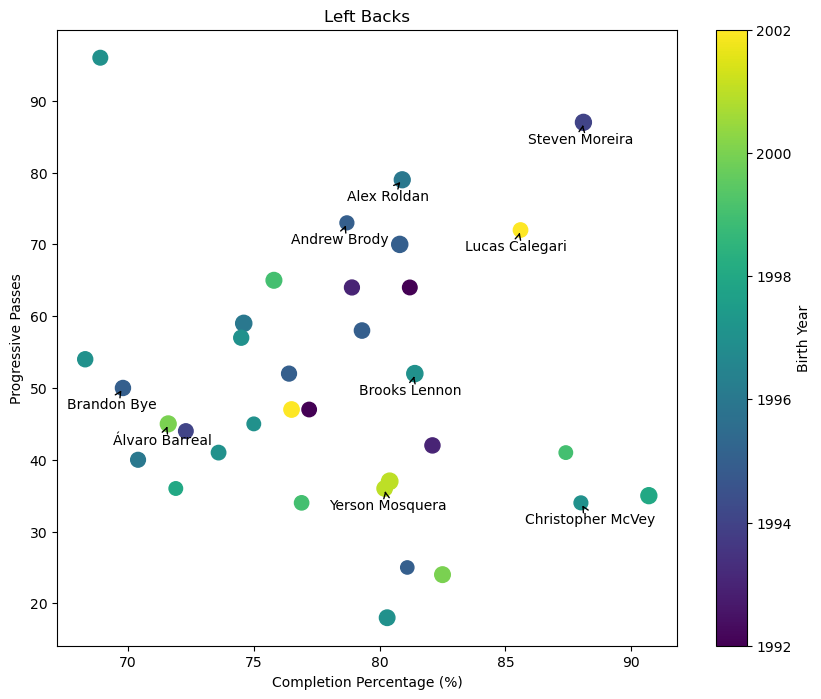

In [524]:
fig, ax = plt.subplots(figsize=(10, 8))
columns = ["Cmp%", "Tkl%"]
for col in columns:
    potentialLB[col] = pd.to_numeric(potentialLB[col], errors = "coerce")
    potentialRB[col] = pd.to_numeric(potentialRB[col], errors = "coerce")

#print(type(potentialLB["Cmp%"][637]))
#print(potentialLB["Cmp%"].unique())
scatter = ax.scatter(potentialLB["Cmp%"], potentialLB["PrgP"], label =potentialLB.Player, cmap='viridis', marker='o', s = potentialLB.Min/10, c = potentialLB.Born)

#keyPlayers = list(potentialLB.Player)
annotations = []
for j, row in potentialLB.iterrows():
    if (row["Player"] in keyPlayers):
        ax.annotate(row['Player'], (row["Cmp%"], row["PrgP"]), xytext=(-40, -15), textcoords='offset points', arrowprops=dict(arrowstyle='->'))
        
#ax.legend()
ax.set_xlabel('Completion Percentage (%)')
ax.set_ylabel('Progressive Passes')
ax.set_title('Left Backs')
colorbar = plt.colorbar(scatter, ax=ax)

#ticks = np.linspace(0, 3, 4)
#labels = ['Goalkeeper', 'Forward', 'Defender', 'Midfielder']
#colorbar.set_ticks(ticks)
#colorbar.set_ticklabels(labels)


colorbar.set_label('Birth Year')

plt.show()

In [525]:
potentialLB.sort_values("Passing", ascending= False)

,Player,Min,npxG/Sh,np:G-xG,Gls,xG,xAG,SoT%,Sh/90,SoT/90,...,PrgP,Tkl+Int,Clr,Cmp%,Tkl%,Born,Lost,Err,Mis,Passing
6,Alex Roldan,1301,0.05,-0.4,0.0,0.4,3.7,0.0,0.55,0.00,...,79.0,46.0,27.0,80.9,61.3,1996.0,12,1.0,13,0.786463
28,Andrew Brody,994,0.05,-0.2,0.0,0.2,1.2,100.0,0.27,0.27,...,73.0,20.0,22.0,78.7,50.0,1995.0,6,0.0,14,0.640828
25,Arnaud Souquet,1078,0.04,-0.2,0.0,0.2,1.0,16.7,0.50,0.08,...,47.0,38.0,25.0,77.2,40.9,1992.0,13,0.0,18,0.619825
21,Eduard Löwen,1112,0.04,0.5,4.0,3.0,1.6,25.7,2.83,0.73,...,96.0,45.0,16.0,68.9,33.3,1997.0,30,0.0,33,0.586799
26,Lucas Calegari,1069,0.07,-0.6,0.0,0.6,1.8,33.3,0.76,0.25,...,72.0,37.0,14.0,85.6,63.6,2002.0,8,1.0,11,0.572468
7,Álvaro Barreal,1294,0.05,0.9,2.0,1.1,3.6,33.3,1.46,0.49,...,45.0,55.0,21.0,71.6,41.0,2000.0,23,0.0,25,0.548060
15,Brandon Bye,1170,0.19,-0.5,1.0,1.5,2.3,12.5,0.62,0.08,...,50.0,35.0,42.0,69.8,62.5,1995.0,6,0.0,17,0.542488
2,Brooks Lennon,1350,0.06,0.7,1.0,0.3,3.3,40.0,0.33,0.13,...,52.0,27.0,37.0,81.4,56.3,1997.0,7,0.0,12,0.524560
16,D.J. Taylor,1169,0.06,-0.5,0.0,0.5,1.1,11.1,0.69,0.08,...,54.0,40.0,48.0,68.3,52.2,1997.0,11,0.0,2,0.503015
13,Franco Negri,1202,0.03,0.6,1.0,0.4,1.7,26.7,1.12,0.30,...,58.0,60.0,24.0,79.3,56.3,1995.0,14,0.0,17,0.500644


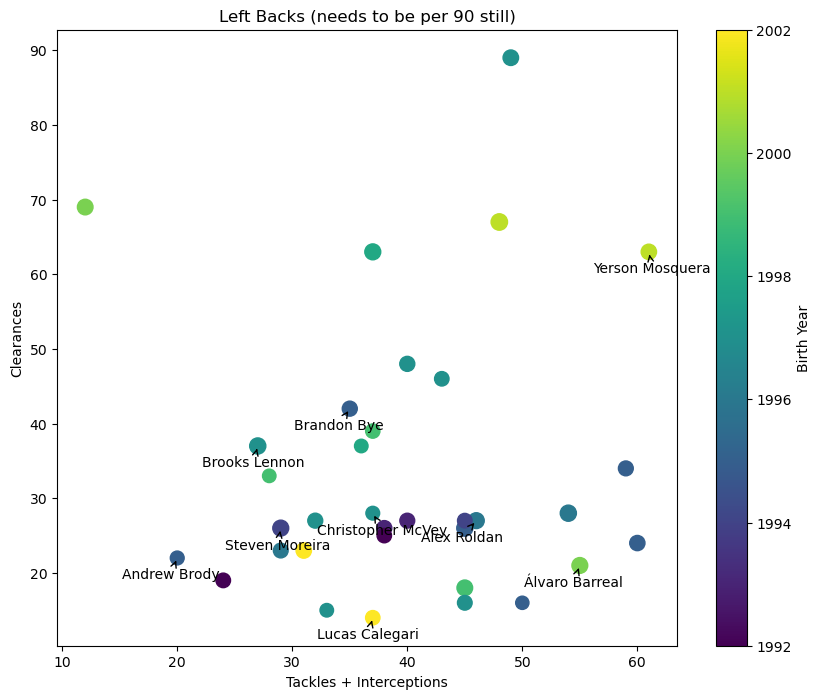

In [526]:
fig, ax = plt.subplots(figsize=(10, 8))
columns = ["Tkl+Int", "Clr"]
for col in columns:
    potentialLB[col] = pd.to_numeric(potentialLB[col], errors = "coerce")
    potentialRB[col] = pd.to_numeric(potentialRB[col], errors = "coerce")

#print(type(potentialLB["Cmp%"][637]))
#print(potentialLB["Cmp%"].unique())
scatter = ax.scatter(potentialLB["Tkl+Int"], potentialLB["Clr"], label =potentialLB.Player, cmap='viridis', marker='o', s = potentialLB.Min/10, c = potentialLB.Born)

#keyPlayers = list(potentialLB.Player)
annotations = []
for j, row in potentialLB.iterrows():
    if (row["Player"] in keyPlayers):
        ax.annotate(row['Player'], (row["Tkl+Int"], row["Clr"]), xytext=(-40, -15), textcoords='offset points', arrowprops=dict(arrowstyle='->'))
        
#ax.legend()
ax.set_xlabel('Tackles + Interceptions')
ax.set_ylabel('Clearances')
ax.set_title('Left Backs (needs to be per 90 still)')
colorbar = plt.colorbar(scatter, ax=ax)

#ticks = np.linspace(0, 3, 4)
#labels = ['Goalkeeper', 'Forward', 'Defender', 'Midfielder']
#colorbar.set_ticks(ticks)
#colorbar.set_ticklabels(labels)


colorbar.set_label('Birth Year')

plt.show()

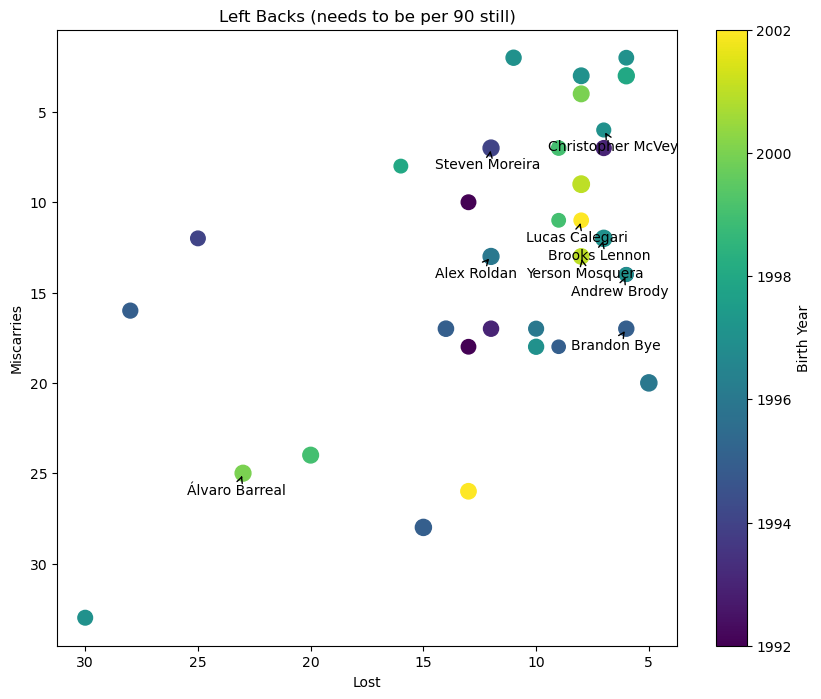

In [527]:
fig, ax = plt.subplots(figsize=(10, 8))
columns = ["Tkl+Int", "Clr"]
for col in columns:
    potentialLB[col] = pd.to_numeric(potentialLB[col], errors = "coerce")
    potentialRB[col] = pd.to_numeric(potentialRB[col], errors = "coerce")

#print(type(potentialLB["Cmp%"][637]))
#print(potentialLB["Cmp%"].unique())
scatter = ax.scatter(potentialLB["Lost"], potentialLB["Mis"], label =potentialLB.Player, cmap='viridis', marker='o', s = potentialLB.Min/10, c = potentialLB.Born)

#keyPlayers = list(potentialLB.Player)
annotations = []
for j, row in potentialLB.iterrows():
    if (row["Player"] in keyPlayers):
        ax.annotate(row['Player'], (row["Lost"], row["Mis"]), xytext=(-40, -15), textcoords='offset points', arrowprops=dict(arrowstyle='->'))
        
#ax.legend()
ax.set_xlabel('Lost')
ax.set_ylabel('Miscarries')
ax.set_title('Left Backs (needs to be per 90 still)')
colorbar = plt.colorbar(scatter, ax=ax)

#ticks = np.linspace(0, 3, 4)
#labels = ['Goalkeeper', 'Forward', 'Defender', 'Midfielder']
#colorbar.set_ticks(ticks)
#colorbar.set_ticklabels(labels)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

colorbar.set_label('Birth Year')

plt.show()

In [518]:
strikers = df.loc[df["FArea"] == "FW"].loc[df.MP >= 2].reset_index(drop=True)
#npxG/Sh	G-xG	np:G-xG
strikers.loc[strikers["Squad"] == "Seattle"].loc[:, ["Player", "Min", "npxG/Sh", "np:G-xG", "Gls", "xG", "xA", "Min"]] 

,Player,Min,npxG/Sh,np:G-xG,Gls,xG,xA,Min
33,Léo Chú,788,0.07,0.1,1.0,0.9,2.6,788
61,Héber,737,0.22,-3.9,2.0,5.9,0.9,737
91,Fredy Montero,330,0.06,0.3,1.0,0.7,0.9,330
93,Jordan Morris,1167,0.28,1.7,9.0,7.3,1.3,1167
113,Cristian Roldan,602,0.24,-0.4,1.0,1.4,0.9,602
116,Raúl Ruidíaz,281,0.15,-0.9,2.0,2.9,0.3,281


In [519]:
strikers = df.loc[df["FArea"] == "FW"].loc[df.MP >= 2].reset_index(drop=True)
#npxG/Sh	G-xG	np:G-xG
strikers.loc[strikers["Squad"] == "New England"].loc[:, ["Player", "Min", "npxG/Sh", "np:G-xG", "Gls", "xG", "xA", "Min"]] 

,Player,Min,npxG/Sh,np:G-xG,Gls,xG,xA,Min
3,Jozy Altidore,158,0.30,-0.2,1.0,1.2,0.1,158
22,Gustavo Bou,434,0.11,0.0,2.0,2.0,0.6,434
109,Justin Rennicks,282,0.25,-0.5,0.0,0.5,0.2,282
142,Giacomo Vrioni,476,0.17,0.3,3.0,2.7,0.1,476
145,Bobby Wood,780,0.18,1.3,5.0,3.7,0.2,780


In [182]:
strikers.loc[strikers["Squad"] == "Seattle"]["np:G-xG"]

23    0.1
42   -3.9
66    0.3
82   -0.9
Name: np:G-xG, dtype: float64

In [185]:
df.loc[df["Player"] == "Jordan Morris"]["Advanced Position"]

439    AM
Name: Advanced Position, dtype: object

In [422]:
#striking = strikers.sort_values("xG", ascending = False).loc[:, ["Player", "Squad", "MP", "Min", "Advanced Position", "npxG/Sh", "np:G-xG", "Gls", "xG", "xAG", "SoT%","Sh/90","SoT/90", "Dist", "G+A.1", "xG.1", "xAG.1"]].reset_index(drop=True)
strikers = df.loc[df["FArea"] == "FW"].loc[df.MP >= 5].reset_index(drop=True)
striking = strikers.sort_values("xG", ascending = False).loc[:, ["Player","Min", "npxG/Sh", "np:G-xG", "Gls", "xG", "xAG", "SoT%","Sh/90","SoT/90", "Dist", "xAG.1", "Ast", "xA","KP","1/3","PPA","CrsPA","PrgP"]].reset_index(drop=True)
columns = ["npxG/Sh", "np:G-xG", "Gls", "xG", "xAG", "SoT%","Sh/90","SoT/90", "Dist", "xAG.1", "Ast", "xA","KP","1/3","PPA","CrsPA","PrgP"]
striking['Min'] = pd.to_numeric(striking['Min'].str.replace(',', ''), errors='coerce')
striking = striking[(striking['Dist'] != 0)]
for col in columns:
    striking[col] = pd.to_numeric(striking[col], errors = "coerce")
#striking.drop(92)
striking = striking.rename(columns={'xAG.1': 'xAGp90', 'Dist': 'ShotDist'})
striking["xA+xG"] = striking["xA"]+ striking["xG"]
striking = striking.loc[striking.Min >900]
striking["Passing"] = (striking["KP"]*90/striking["Min"])/striking["KP"].mean()+(striking["1/3"]*90/striking["Min"])/striking["1/3"].mean()+ (striking["PPA"]*90/striking["Min"])/striking["PPA"].mean()+(striking["CrsPA"]*90/striking["Min"])/striking["CrsPA"].mean()+(striking["PrgP"]*90/striking["Min"])/striking["PrgP"].mean()

# My All-Star strikers: Brian White, Denis Bouanga, Jordan Morris; honorable mention: Jesus Ferreira

In [419]:
striking.sort_values("xA+xG", ascending = False)[0:20]

,Player,Min,npxG/Sh,np:G-xG,Gls,xG,xAG,SoT%,Sh/90,SoT/90,...,xAGp90,Ast,xA,KP,1/3,PPA,CrsPA,PrgP,xA+xG,Passing
3,Hany Mukhtar,1229,0.08,1.5,9.0,6.7,4.4,38.2,4.03,1.54,...,0.32,6.0,3.3,30.0,35.0,15.0,2,55.0,10.0,0.997608
0,Brian White,993,0.18,-2.1,6.0,8.1,1.3,45.5,3.99,1.81,...,0.12,1.0,1.5,11.0,10.0,6.0,0,15.0,9.6,0.356728
2,Dániel Gazdag,1181,0.09,-1.1,7.0,6.8,2.9,29.2,1.83,0.53,...,0.22,4.0,2.8,20.0,51.0,16.0,0,67.0,9.6,0.996502
6,Bongokuhle Hlongwane,1235,0.17,-2.4,4.0,6.4,1.5,40.0,2.91,1.17,...,0.11,0.0,2.9,10.0,22.0,14.0,1,40.0,9.3,0.607218
1,Jordan Morris,1167,0.28,1.7,9.0,7.3,1.9,44.4,2.08,0.93,...,0.15,0.0,1.3,15.0,11.0,9.0,2,20.0,8.6,0.531215
4,Julián Carranza,1146,0.15,0.4,7.0,6.6,2.0,41.9,3.38,1.41,...,0.16,2.0,1.9,15.0,20.0,10.0,1,32.0,8.5,0.602759
8,Jesús Ferreira,1264,0.16,3.0,9.0,6.0,1.8,39.5,2.71,1.07,...,0.13,0.0,2.0,24.0,33.0,13.0,4,53.0,8.0,0.995387
7,Christian Benteke,1348,0.13,1.0,7.0,6.0,2.1,29.2,3.20,0.93,...,0.14,2.0,1.1,21.0,30.0,13.0,1,47.0,7.1,0.704613
15,Denis Bouanga,919,0.07,5.6,10.0,4.2,3.6,41.3,4.50,1.86,...,0.35,1.0,2.5,18.0,11.0,15.0,0,31.0,6.7,0.695094
47,Dániel Sallói,1402,0.06,1.6,4.0,2.4,2.7,50.0,2.57,1.28,...,0.17,3.0,3.7,31.0,25.0,28.0,9,59.0,6.1,1.341284


In [421]:
striking.PrgP.mean()

40.48148148148148

In [423]:
striking.sort_values("Passing", ascending = False)[0:20]

,Player,Min,npxG/Sh,np:G-xG,Gls,xG,xAG,SoT%,Sh/90,SoT/90,...,xAGp90,Ast,xA,KP,1/3,PPA,CrsPA,PrgP,xA+xG,Passing
47,Dániel Sallói,1402,0.06,1.6,4.0,2.4,2.7,50.0,2.57,1.28,...,0.17,3.0,3.7,31.0,25.0,28.0,9,59.0,6.1,0.692133
88,Brian Gutiérrez,988,0.08,-1.1,0.0,1.1,1.8,14.3,1.28,0.18,...,0.16,3.0,2.1,13.0,46.0,18.0,3,79.0,3.2,0.687681
31,Federico Bernardeschi,1261,0.06,-0.2,3.0,3.0,3.1,40.0,2.50,1.00,...,0.22,2.0,2.8,28.0,25.0,25.0,5,45.0,5.8,0.582607
84,Alan Velasco,982,0.05,0.8,2.0,1.2,1.5,38.5,2.38,0.92,...,0.14,1.0,1.8,14.0,25.0,13.0,5,43.0,3.0,0.581526
71,Iván Angulo,1032,0.09,0.5,2.0,1.5,0.6,22.2,1.57,0.35,...,0.06,0.0,1.5,7.0,14.0,18.0,6,43.0,3.0,0.545912
28,Luiz Araújo,1189,0.06,0.7,3.0,3.1,1.4,30.8,2.95,0.91,...,0.11,1.0,2.3,19.0,24.0,25.0,3,64.0,5.4,0.537192
105,Indiana Vassilev,918,0.05,1.3,2.0,0.7,1.0,31.3,1.57,0.49,...,0.10,1.0,0.9,13.0,34.0,12.0,2,41.0,1.6,0.506124
8,Jesús Ferreira,1264,0.16,3.0,9.0,6.0,1.8,39.5,2.71,1.07,...,0.13,0.0,2.0,24.0,33.0,13.0,4,53.0,8.0,0.505863
67,Alexandru Mățan,1092,0.10,-0.8,1.0,1.8,2.1,22.2,1.48,0.33,...,0.17,4.0,2.3,14.0,37.0,20.0,1,65.0,4.1,0.501412
3,Hany Mukhtar,1229,0.08,1.5,9.0,6.7,4.4,38.2,4.03,1.54,...,0.32,6.0,3.3,30.0,35.0,15.0,2,55.0,10.0,0.500511


In [408]:
striking.sort_values("xG", ascending = False)[0:20]

,Player,Min,npxG/Sh,np:G-xG,Gls,xG,xAG,SoT%,Sh/90,SoT/90,...,GlsAstsp90,xAGp90,Ast,xA,KP,1/3,PPA,CrsPA,PrgP,xA+xG
0,Brian White,993,0.18,-2.1,6.0,8.1,1.3,45.5,3.99,1.81,...,0.63,0.12,1.0,1.5,11.0,10.0,6.0,0,15.0,9.6
1,Jordan Morris,1167,0.28,1.7,9.0,7.3,1.9,44.4,2.08,0.93,...,0.69,0.15,0.0,1.3,15.0,11.0,9.0,2,20.0,8.6
2,Dániel Gazdag,1181,0.09,-1.1,7.0,6.8,2.9,29.2,1.83,0.53,...,0.84,0.22,4.0,2.8,20.0,51.0,16.0,0,67.0,9.6
3,Hany Mukhtar,1229,0.08,1.5,9.0,6.7,4.4,38.2,4.03,1.54,...,1.10,0.32,6.0,3.3,30.0,35.0,15.0,2,55.0,10.0
4,Julián Carranza,1146,0.15,0.4,7.0,6.6,2.0,41.9,3.38,1.41,...,0.71,0.16,2.0,1.9,15.0,20.0,10.0,1,32.0,8.5
6,Bongokuhle Hlongwane,1235,0.17,-2.4,4.0,6.4,1.5,40.0,2.91,1.17,...,0.29,0.11,0.0,2.9,10.0,22.0,14.0,1,40.0,9.3
7,Christian Benteke,1348,0.13,1.0,7.0,6.0,2.1,29.2,3.20,0.93,...,0.60,0.14,2.0,1.1,21.0,30.0,13.0,1,47.0,7.1
8,Jesús Ferreira,1264,0.16,3.0,9.0,6.0,1.8,39.5,2.71,1.07,...,0.64,0.13,0.0,2.0,24.0,33.0,13.0,4,53.0,8.0
10,Brandon Vazquez,1317,0.11,-1.2,4.0,5.0,1.5,35.1,2.53,0.89,...,0.34,0.10,1.0,0.8,8.0,12.0,9.0,2,23.0,5.8
12,Karol Świderski,1111,0.10,-0.7,4.0,4.4,1.2,27.0,3.00,0.81,...,0.49,0.09,2.0,1.6,11.0,16.0,10.0,2,33.0,6.0


In [411]:
striking = striking.loc[striking.Min >900]

,Player,Min,npxG/Sh,np:G-xG,Gls,xG,xAG,SoT%,Sh/90,SoT/90,...,GlsAstsp90,xAGp90,Ast,xA,KP,1/3,PPA,CrsPA,PrgP,xA+xG
0,Brian White,993,0.18,-2.1,6.0,8.1,1.3,45.5,3.99,1.81,...,0.63,0.12,1.0,1.5,11.0,10.0,6.0,0,15.0,9.6
1,Jordan Morris,1167,0.28,1.7,9.0,7.3,1.9,44.4,2.08,0.93,...,0.69,0.15,0.0,1.3,15.0,11.0,9.0,2,20.0,8.6
2,Dániel Gazdag,1181,0.09,-1.1,7.0,6.8,2.9,29.2,1.83,0.53,...,0.84,0.22,4.0,2.8,20.0,51.0,16.0,0,67.0,9.6
3,Hany Mukhtar,1229,0.08,1.5,9.0,6.7,4.4,38.2,4.03,1.54,...,1.10,0.32,6.0,3.3,30.0,35.0,15.0,2,55.0,10.0
4,Julián Carranza,1146,0.15,0.4,7.0,6.6,2.0,41.9,3.38,1.41,...,0.71,0.16,2.0,1.9,15.0,20.0,10.0,1,32.0,8.5
6,Bongokuhle Hlongwane,1235,0.17,-2.4,4.0,6.4,1.5,40.0,2.91,1.17,...,0.29,0.11,0.0,2.9,10.0,22.0,14.0,1,40.0,9.3
7,Christian Benteke,1348,0.13,1.0,7.0,6.0,2.1,29.2,3.20,0.93,...,0.60,0.14,2.0,1.1,21.0,30.0,13.0,1,47.0,7.1
8,Jesús Ferreira,1264,0.16,3.0,9.0,6.0,1.8,39.5,2.71,1.07,...,0.64,0.13,0.0,2.0,24.0,33.0,13.0,4,53.0,8.0
10,Brandon Vazquez,1317,0.11,-1.2,4.0,5.0,1.5,35.1,2.53,0.89,...,0.34,0.10,1.0,0.8,8.0,12.0,9.0,2,23.0,5.8
12,Karol Świderski,1111,0.10,-0.7,4.0,4.4,1.2,27.0,3.00,0.81,...,0.49,0.09,2.0,1.6,11.0,16.0,10.0,2,33.0,6.0


In [393]:
striking = striking.sort_values("np:G-xG", ascending=False).loc[striking.Min >900].reset_index(drop=True)
striking

,Player,Min,AdPos,npxG/Sh,np:G-xG,Gls,xG,xAG,SoT%,Sh/90,...,ShotDist,GlsAstsp90,xAGp90,Ast,xA,KP,1/3,PPA,CrsPA,PrgP
0,Denis Bouanga,919,AM,0.07,5.6,10.0,4.2,3.6,41.3,4.50,...,19.5,1.08,0.35,1.0,2.5,18.0,11.0,15.0,0,31.0
1,Jesús Ferreira,1264,FW,0.16,3.0,9.0,6.0,1.8,39.5,2.71,...,13.9,0.64,0.13,0.0,2.0,24.0,33.0,13.0,4,53.0
2,Nicholas Gioacchini,922,FW,0.11,2.5,4.0,1.5,1.3,50.0,1.37,...,12.2,0.49,0.13,1.0,1.0,16.0,8.0,4.0,1,17.0
3,Jordan Morris,1167,AM,0.28,1.7,9.0,7.3,1.9,44.4,2.08,...,11.2,0.69,0.15,0.0,1.3,15.0,11.0,9.0,2,20.0
4,Dániel Sallói,1402,FW,0.06,1.6,4.0,2.4,2.7,50.0,2.57,...,20.2,0.45,0.17,3.0,3.7,31.0,25.0,28.0,9,59.0
5,Gabriel Pereira,1060,FW,0.09,1.6,4.0,2.4,2.4,48.1,2.29,...,17.9,0.59,0.21,3.0,2.8,23.0,15.0,20.0,1,50.0
6,Hany Mukhtar,1229,FW,0.08,1.5,9.0,6.7,4.4,38.2,4.03,...,20.8,1.10,0.32,6.0,3.3,30.0,35.0,15.0,2,55.0
7,Jeremy Ebobisse,1333,FW,0.14,1.5,6.0,4.3,1.0,36.0,1.69,...,17.1,0.41,0.07,0.0,1.6,11.0,23.0,14.0,1,46.0
8,Indiana Vassilev,918,FW,0.05,1.3,2.0,0.7,1.0,31.3,1.57,...,22.9,0.29,0.10,1.0,0.9,13.0,34.0,12.0,2,41.0
9,Enzo Copetti,1140,FW,0.16,1.3,4.0,2.7,0.9,41.2,1.34,...,9.3,0.32,0.07,0.0,0.7,12.0,12.0,5.0,0,18.0


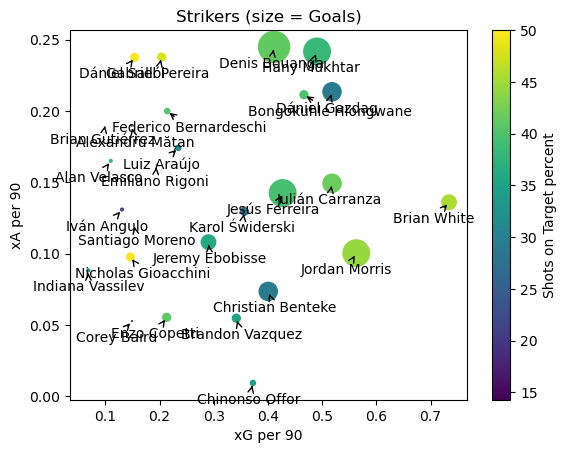

In [412]:
plt.scatter(striking.xG*90/striking.Min, striking.xA*90/striking.Min, s = striking.Gls*striking.Gls*striking.Gls/2, c = striking["SoT%"])
keyPlayers = list(striking.Player)
#annotations = []
for j, row in striking.iterrows():
    if (row["Player"] in keyPlayers):
        plt.annotate(row['Player'], (row["xG"]*90/row.Min, row["xA"]*90/row.Min), xytext=(-40, -15), textcoords='offset points', arrowprops=dict(arrowstyle='->'))

plt.xlabel('xG per 90')
plt.ylabel('xA per 90')
plt.title('Strikers (size = Goals)')
colorbar = plt.colorbar()

#ticks = np.linspace(0, 3, 4)
#labels = ['Goalkeeper', 'Forward', 'Defender', 'Midfielder']
#colorbar.set_ticks(ticks)
#colorbar.set_ticklabels(labels)


colorbar.set_label('Shots on Target percent')
plt.show()

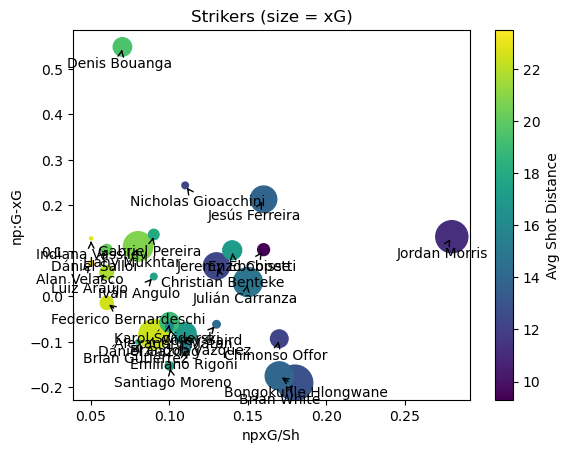

In [413]:
plt.scatter(striking["npxG/Sh"], striking["np:G-xG"]*90/striking.Min, s = striking.xG*striking.xG*10, c = striking["ShotDist"])
keyPlayers = list(striking.Player)
#print(keyPlayers)
#annotations = []
for j, row in striking.iterrows():
    #print(row["Player"])
    if (row["Player"] in keyPlayers):
     #   print(row)
        plt.annotate(row['Player'], (row["npxG/Sh"], row["np:G-xG"]*90/row.Min), xytext=(-40, -15), textcoords='offset points', arrowprops=dict(arrowstyle='->'))

plt.xlabel('npxG/Sh')
plt.ylabel('np:G-xG')
plt.title('Strikers (size = xG)')
colorbar = plt.colorbar()

#ticks = np.linspace(0, 3, 4)
#labels = ['Goalkeeper', 'Forward', 'Defender', 'Midfielder']
#colorbar.set_ticks(ticks)
#colorbar.set_ticklabels(labels)


colorbar.set_label('Avg Shot Distance')
plt.show()

In [532]:
strikers.loc[strikers.Squad == "FC Cincinnati"]


,Unnamed: 0,Player,Nation,Pos,Squad,Age,Born,MP,Starts,Min,...,TklW.1,PKwon,PKcon,OG,Recov,Won,Lost.1,Won%,Matches.9,FArea
10,47,Dominique Badji,sn SEN,FW,FC Cincinnati,30-228,1992.0,11.0,4.0,364,...,3.0,1.0,0.0,0.0,12.0,9.0,8.0,52.9,Matches,FW
25,102,Brenner,br BRA,FW,FC Cincinnati,23-136,2000.0,8.0,6.0,534,...,5.0,0.0,0.0,0.0,29.0,2.0,1.0,66.7,Matches,FW
103,500,Arquimides Ordonez,gt GUA,FW,FC Cincinnati,19-300,2003.0,3.0,1.0,61,...,1.0,0.0,0.0,0.0,4.0,0.0,3.0,0.0,Matches,FW
120,606,Sergio Santos Gomes,br BRA,FW,FC Cincinnati,28-270,1994.0,12.0,5.0,447,...,9.0,0.0,0.0,0.0,22.0,11.0,18.0,37.9,Matches,FW
138,689,Brandon Vazquez,us USA,FW,FC Cincinnati,24-230,1998.0,15.0,15.0,1317,...,8.0,0.0,0.0,0.0,38.0,45.0,44.0,50.6,Matches,FW


In [616]:
potentialCB = df.loc[(df["Advanced Position"] == 'DF') | (df["Advanced Position"] == 'CB') | (df["Advanced Position"] == 'RCB') | (df["Advanced Position"] == 'LCB')].loc[df.Min >= 900].reset_index(drop=True)
#potentialLB = potentialLB.loc[(df["Advanced Position"] == 'LB') | (df["Advanced Position"] == 'FB')]
#po = df.loc[df["FArea"] == "FW"].loc[df.MP >= 5].reset_index(drop=True)
potentialCB = potentialCB.sort_values("Min", ascending = False).loc[:, ["Player","Min", "npxG/Sh", "np:G-xG", "Gls", "xG", "xAG", "SoT%","Sh/90","SoT/90", "Dist", "xAG.1", "Ast", "xA","KP","1/3","PPA","CrsPA","PrgP", "Tkl+Int", "Clr", "Cmp%", "Tkl%", "Born", "Lost", "Err", "Mis"]].reset_index(drop=True)
columns = ["npxG/Sh", "np:G-xG", "Gls", "xG", "xAG", "SoT%","Sh/90","SoT/90", "Dist", "xAG.1", "Ast", "xA","KP","1/3","PPA","CrsPA","PrgP", "Tkl+Int", "Clr", "Cmp%", "Tkl%", "Born", "Lost", "Err", "Mis"]
for col in columns:
    potentialCB[col] = pd.to_numeric(potentialCB[col], errors = "coerce")
keyPlayers = list(potentialCB.Player)
potentialCB["Passing"] = (potentialCB["KP"]*90/potentialCB["Min"])/potentialCB["KP"].mean()+(potentialCB["1/3"]*90/potentialCB["Min"])/potentialCB["1/3"].mean()+ (potentialCB["PPA"]*90/potentialCB["Min"])/potentialCB["PPA"].mean()+(potentialCB["CrsPA"]*90/potentialCB["Min"])/potentialCB["CrsPA"].mean()+(potentialCB["PrgP"]*90/potentialCB["Min"])/potentialCB["PrgP"].mean()
keyPlayers = ["Jackson Ragen", "Miles Robinson", "Zac McGraw", "Matt Miazga", "Rodrigues", "Yeimar Gómez Andrade", "Jack Maher", "Adilson Malanda", "Jakob Glesnes", "David Romney", "Sean Nealis", "James Sands", "Andreu Fontàs", "Rafael Czichos"]
keyPlayers = ["Walker Zimmerman", "Mark McKenzie", "Miles Robinson", "Matt Miazga"]

#keyPlayers = ["Zac McGraw", "Ethan Bartlow", "Eduard Löwen", "Jon Gallagher", "Andrew Gutman"]
#MLS AllStar Center Backs: Zac McGraw, Matt Miazga; Honorable Mentions: Jackson Tagen, James Sands

In [617]:
potentialCB.sort_values("Passing", ascending=False)

,Player,Min,npxG/Sh,np:G-xG,Gls,xG,xAG,SoT%,Sh/90,SoT/90,...,PrgP,Tkl+Int,Clr,Cmp%,Tkl%,Born,Lost,Err,Mis,Passing
12,Álvaro Barreal,1294,0.05,0.9,2.0,1.1,3.6,33.3,1.46,0.49,...,45.0,55.0,21.0,71.6,41.0,2000.0,23,0.0,25,1.534921
29,Franco Negri,1202,0.03,0.6,1.0,0.4,1.7,26.7,1.12,0.30,...,58.0,60.0,24.0,79.3,56.3,1995.0,14,0.0,17,1.420363
23,Juan Mosquera,1221,0.13,0.2,2.0,1.8,1.4,35.7,1.03,0.37,...,47.0,31.0,23.0,76.5,35.0,2002.0,13,0.0,26,1.324972
38,Eduard Löwen,1112,0.04,0.5,4.0,3.0,1.6,25.7,2.83,0.73,...,96.0,45.0,16.0,68.9,33.3,1997.0,30,0.0,33,1.249922
15,Mathieu Choiniere,1271,0.07,0.3,2.0,1.7,2.1,43.5,1.63,0.71,...,65.0,45.0,18.0,75.8,35.5,1999.0,20,0.0,24,1.192280
44,Javain Brown,1059,0.08,-0.1,1.0,1.1,0.9,23.1,1.10,0.25,...,34.0,37.0,39.0,76.9,57.1,1999.0,9,1.0,7,1.189969
36,Jon Gallagher,1127,0.13,3.0,5.0,2.0,1.4,53.3,1.20,0.64,...,40.0,29.0,23.0,70.4,56.5,1996.0,10,1.0,17,0.782051
53,John Nelson,949,0.10,-0.3,0.0,0.3,0.4,33.3,0.28,0.09,...,36.0,36.0,37.0,71.9,48.4,1998.0,16,1.0,8,0.716851
47,Nkosi Tafari,1022,0.05,1.6,2.0,0.4,0.6,25.0,0.70,0.18,...,43.0,21.0,49.0,82.4,76.9,1997.0,3,0.0,6,0.555890
19,Danny Wilson,1255,0.14,-0.4,1.0,1.4,0.9,30.0,0.72,0.22,...,52.0,25.0,57.0,77.9,35.0,1991.0,13,1.0,5,0.528999


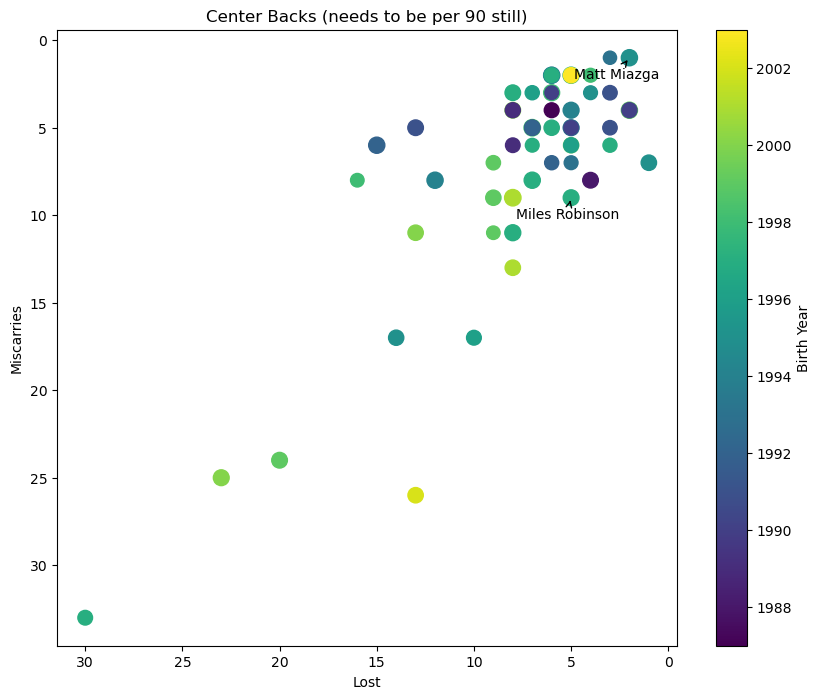

In [618]:
fig, ax = plt.subplots(figsize=(10, 8))
columns = ["Tkl+Int", "Clr"]
for col in columns:
    potentialLB[col] = pd.to_numeric(potentialLB[col], errors = "coerce")
    potentialRB[col] = pd.to_numeric(potentialRB[col], errors = "coerce")

#print(type(potentialLB["Cmp%"][637]))
#print(potentialLB["Cmp%"].unique())
scatter = ax.scatter(potentialCB["Lost"], potentialCB["Mis"], label =potentialCB.Player, cmap='viridis', marker='o', s = potentialCB.Min/10, c = potentialCB.Born)

#keyPlayers = list(potentialLB.Player)
annotations = []
for j, row in potentialCB.iterrows():
    if (row["Player"] in keyPlayers):
        ax.annotate(row['Player'], (row["Lost"], row["Mis"]), xytext=(-40, -15), textcoords='offset points', arrowprops=dict(arrowstyle='->'))
        
#ax.legend()
ax.set_xlabel('Lost')
ax.set_ylabel('Miscarries')
ax.set_title('Center Backs (needs to be per 90 still)')
colorbar = plt.colorbar(scatter, ax=ax)

#ticks = np.linspace(0, 3, 4)
#labels = ['Goalkeeper', 'Forward', 'Defender', 'Midfielder']
#colorbar.set_ticks(ticks)
#colorbar.set_ticklabels(labels)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

colorbar.set_label('Birth Year')

plt.show()

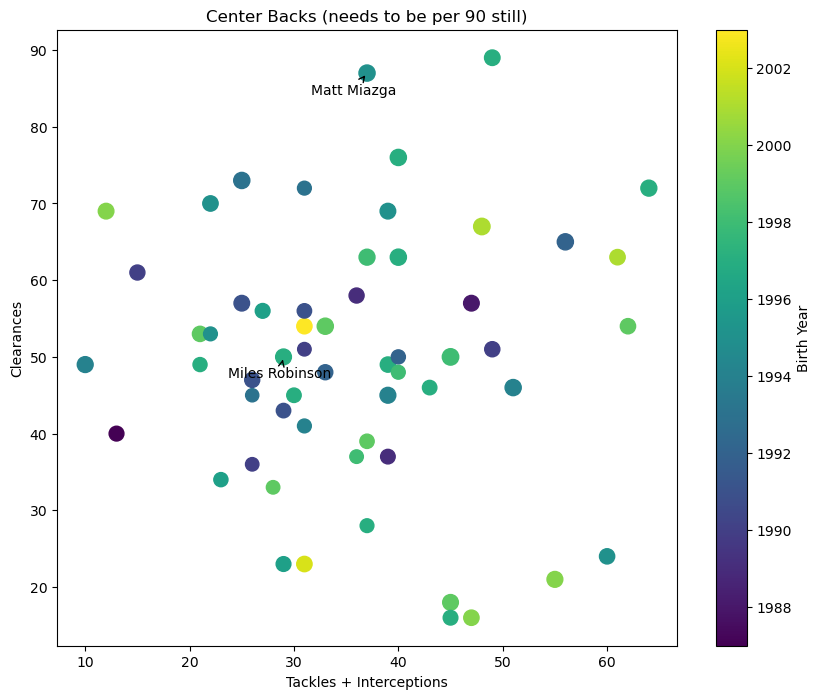

In [619]:
fig, ax = plt.subplots(figsize=(10, 8))
columns = ["Tkl+Int", "Clr"]
for col in columns:
    potentialLB[col] = pd.to_numeric(potentialLB[col], errors = "coerce")
    potentialRB[col] = pd.to_numeric(potentialRB[col], errors = "coerce")

#print(type(potentialLB["Cmp%"][637]))
#print(potentialLB["Cmp%"].unique())
scatter = ax.scatter(potentialCB["Tkl+Int"], potentialCB["Clr"], label =potentialCB.Player, cmap='viridis', marker='o', s = potentialCB.Min/10, c = potentialCB.Born)

#keyPlayers = list(potentialLB.Player)
annotations = []
for j, row in potentialCB.iterrows():
    if (row["Player"] in keyPlayers):
        ax.annotate(row['Player'], (row["Tkl+Int"], row["Clr"]), xytext=(-40, -15), textcoords='offset points', arrowprops=dict(arrowstyle='->'))
        
#ax.legend()
ax.set_xlabel('Tackles + Interceptions')
ax.set_ylabel('Clearances')
ax.set_title('Center Backs (needs to be per 90 still)')
colorbar = plt.colorbar(scatter, ax=ax)

#ticks = np.linspace(0, 3, 4)
#labels = ['Goalkeeper', 'Forward', 'Defender', 'Midfielder']
#colorbar.set_ticks(ticks)
#colorbar.set_ticklabels(labels)


colorbar.set_label('Birth Year')

plt.show()

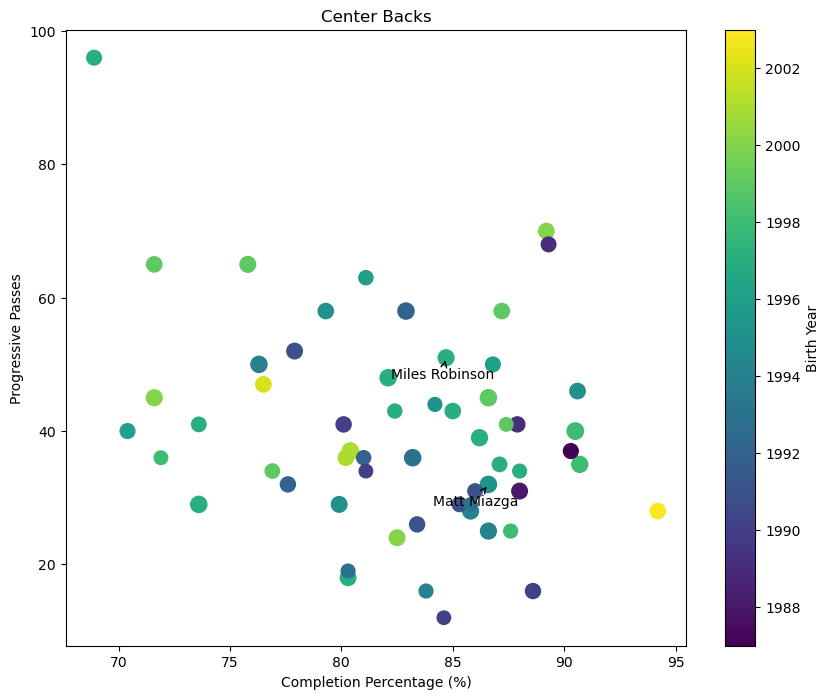

In [620]:
fig, ax = plt.subplots(figsize=(10, 8))
columns = ["Cmp%", "Tkl%"]
for col in columns:
    potentialLB[col] = pd.to_numeric(potentialLB[col], errors = "coerce")
    potentialRB[col] = pd.to_numeric(potentialRB[col], errors = "coerce")

#print(type(potentialLB["Cmp%"][637]))
#print(potentialLB["Cmp%"].unique())
scatter = ax.scatter(potentialCB["Cmp%"], potentialCB["PrgP"], label =potentialCB.Player, cmap='viridis', marker='o', s = potentialCB.Min/10, c = potentialCB.Born)

#keyPlayers = list(potentialLB.Player)
annotations = []
for j, row in potentialCB.iterrows():
    if (row["Player"] in keyPlayers):
        ax.annotate(row['Player'], (row["Cmp%"], row["PrgP"]), xytext=(-40, -15), textcoords='offset points', arrowprops=dict(arrowstyle='->'))
        
#ax.legend()
ax.set_xlabel('Completion Percentage (%)')
ax.set_ylabel('Progressive Passes')
ax.set_title('Center Backs')
colorbar = plt.colorbar(scatter, ax=ax)

#ticks = np.linspace(0, 3, 4)
#labels = ['Goalkeeper', 'Forward', 'Defender', 'Midfielder']
#colorbar.set_ticks(ticks)
#colorbar.set_ticklabels(labels)


colorbar.set_label('Birth Year')

plt.show()

In [610]:
DM = df.loc[(df["Advanced Position"] == 'DM') | (df["Advanced Position"] == 'MF')| (df["Advanced Position"] == 'AM')].loc[df.Min >= 900].reset_index(drop=True)
DM = DM.sort_values("Min", ascending = False).loc[:, ["Player","Min", "npxG/Sh", "np:G-xG", "Gls", "xG", "xAG", "SoT%","Sh/90","SoT/90", "Dist", "xAG.1", "Ast", "xA","KP","1/3","PPA","CrsPA","PrgP", "Tkl+Int", "Clr", "Cmp%", "Tkl%", "Born", "Lost", "Err", "Mis"]].reset_index(drop=True)
columns = ["npxG/Sh", "np:G-xG", "Gls", "xG", "xAG", "SoT%","Sh/90","SoT/90", "Dist", "xAG.1", "Ast", "xA","KP","1/3","PPA","CrsPA","PrgP", "Tkl+Int", "Clr", "Cmp%", "Tkl%", "Born", "Lost", "Err", "Mis"]
for col in columns:
    DM[col] = pd.to_numeric(DM[col], errors = "coerce")
keyPlayers = list(DM.Player)
#keyPlayers = ["Walker Zimmerman", "Mark McKenzie", "Miles Robinson", "Matt Miazga"]
DM["Passing"] = (DM["KP"]*90/DM["Min"])/DM["KP"].mean()+(DM["1/3"]*90/DM["Min"])/DM["1/3"].mean()+ (DM["PPA"]*90/DM["Min"])/DM["PPA"].mean()+(DM["CrsPA"]*90/DM["Min"])/DM["CrsPA"].mean()+(DM["PrgP"]*90/DM["Min"])/DM["PrgP"].mean()
#MLS AllStar DM: Aidan Morris

In [611]:
df["Advanced Position"].unique()

array(['LCB', 'RCB', 'DF', 'DM', 'CM', 'AM', 'RB', 'FW', 'MF', 'LB', 'CB',
       'RAM', 'LAM', 'FB', 'RCM', 'GK', 'RDM', 'LCM', 'WM', 'RM'],
      dtype=object)

In [612]:
DM.sort_values("xG", ascending = False)

,Player,Min,npxG/Sh,np:G-xG,Gls,xG,xAG,SoT%,Sh/90,SoT/90,...,PrgP,Tkl+Int,Clr,Cmp%,Tkl%,Born,Lost,Err,Mis,Passing
18,Jordan Morris,1167,0.28,1.7,9.0,7.3,1.9,44.4,2.08,0.93,...,20.0,9.0,4.0,75.1,50.0,1994.0,3,0.0,18.0,0.190220
23,Luciano Acosta,1133,0.14,0.3,6.0,6.1,3.0,42.9,2.22,0.95,...,79.0,31.0,1.0,70.9,36.0,1994.0,16,1.0,37.0,0.475518
12,Thiago Almada,1238,0.06,2.7,7.0,4.9,7.0,33.3,4.14,1.38,...,141.0,19.0,0.0,81.6,33.3,2001.0,10,0.0,30.0,0.742890
29,Lucas Zelarayán,1078,0.07,1.8,7.0,4.8,3.1,36.4,3.67,1.34,...,103.0,21.0,7.0,73.5,30.0,1992.0,14,0.0,35.0,0.693710
40,Denis Bouanga,919,0.07,5.6,10.0,4.2,3.6,41.3,4.50,1.86,...,31.0,15.0,8.0,69.5,31.6,1994.0,13,0.0,37.0,0.251372
33,Carles Gil,1001,0.11,1.0,5.0,3.8,3.3,44.4,2.43,1.08,...,117.0,16.0,5.0,78.9,26.7,1992.0,11,0.0,22.0,0.716876
13,Erik Thommy,1237,0.06,-0.5,2.0,3.3,1.3,37.2,3.13,1.16,...,75.0,35.0,5.0,80.0,41.4,1994.0,17,1.0,28.0,0.384726
28,Jefferson Savarino,1084,0.08,0.9,4.0,3.1,1.8,35.0,3.32,1.16,...,62.0,15.0,2.0,70.9,25.0,1996.0,12,0.0,25.0,0.474860
26,Ryan Gauld,1108,0.11,-2.1,1.0,3.1,3.8,28.6,2.27,0.65,...,85.0,32.0,4.0,75.7,45.5,1995.0,12,0.0,23.0,0.720170
17,Luiz Araújo,1189,0.06,0.7,3.0,3.1,1.4,30.8,2.95,0.91,...,64.0,27.0,1.0,77.6,35.0,1996.0,13,0.0,31.0,0.364573


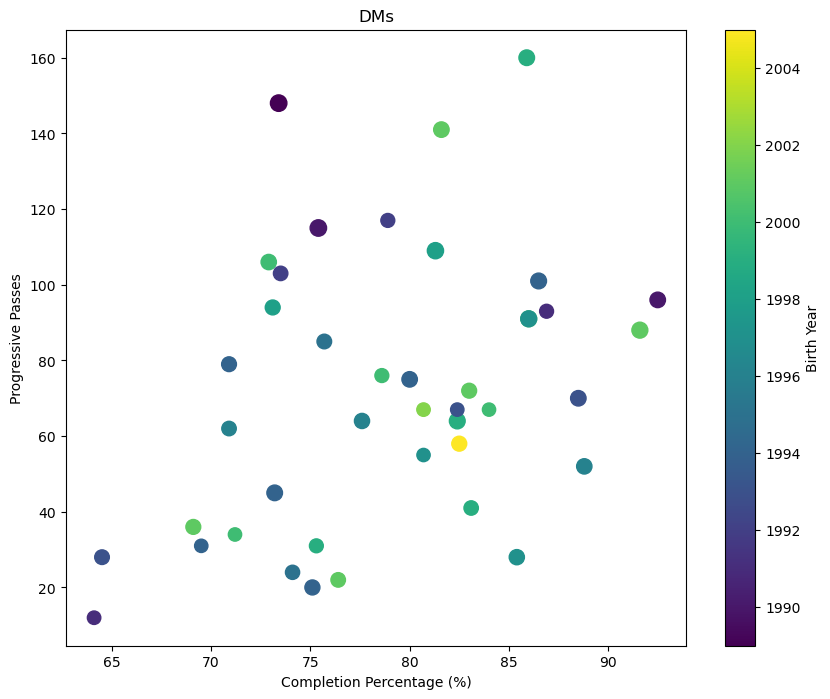

In [613]:
fig, ax = plt.subplots(figsize=(10, 8))

scatter = ax.scatter(DM["Cmp%"], DM["PrgP"], label =DM.Player, cmap='viridis', marker='o', s = DM.Min/10, c = DM.Born)

#keyPlayers = list(potentialLB.Player)
annotations = []
for j, row in DM.iterrows():
    if (row["Player"] in keyPlayers):
        ax.annotate(row['Player'], (row["Cmp%"], row["PrgP"]), xytext=(-40, -15), textcoords='offset points', arrowprops=dict(arrowstyle='->'))
        
#ax.legend()
ax.set_xlabel('Completion Percentage (%)')
ax.set_ylabel('Progressive Passes')
ax.set_title('DMs')
colorbar = plt.colorbar(scatter, ax=ax)

#ticks = np.linspace(0, 3, 4)
#labels = ['Goalkeeper', 'Forward', 'Defender', 'Midfielder']
#colorbar.set_ticks(ticks)
#colorbar.set_ticklabels(labels)


colorbar.set_label('Birth Year')

plt.show()

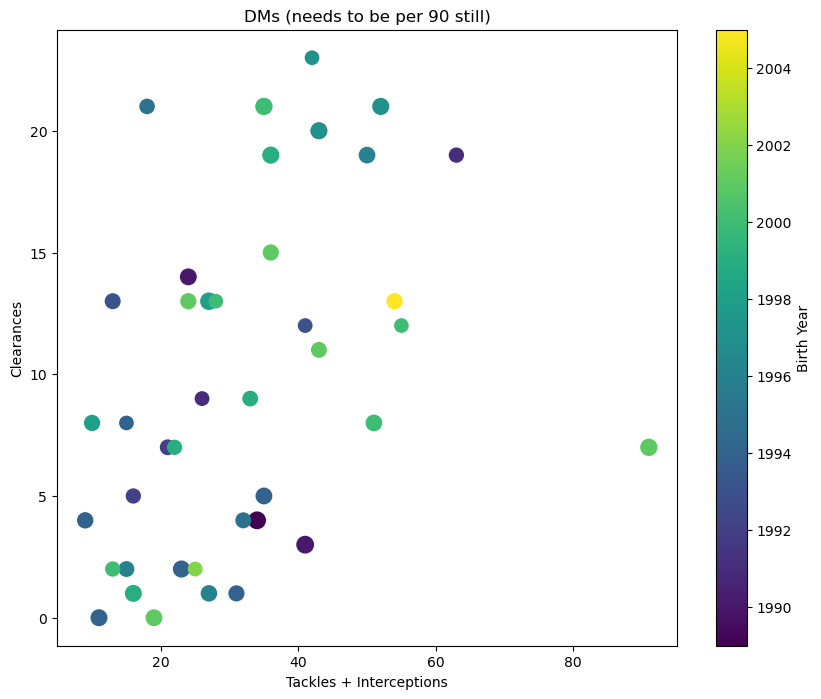

In [614]:
fig, ax = plt.subplots(figsize=(10, 8))
columns = ["Tkl+Int", "Clr"]
for col in columns:
    potentialLB[col] = pd.to_numeric(potentialLB[col], errors = "coerce")
    potentialRB[col] = pd.to_numeric(potentialRB[col], errors = "coerce")

#print(type(potentialLB["Cmp%"][637]))
#print(potentialLB["Cmp%"].unique())
scatter = ax.scatter(DM["Tkl+Int"], DM["Clr"], label =DM.Player, cmap='viridis', marker='o', s = DM.Min/10, c = DM.Born)

#keyPlayers = list(potentialLB.Player)
annotations = []
for j, row in DM.iterrows():
    if (row["Player"] in keyPlayers):
        ax.annotate(row['Player'], (row["Tkl+Int"], row["Clr"]), xytext=(-40, -15), textcoords='offset points', arrowprops=dict(arrowstyle='->'))
        
#ax.legend()
ax.set_xlabel('Tackles + Interceptions')
ax.set_ylabel('Clearances')
ax.set_title('DMs (needs to be per 90 still)')
colorbar = plt.colorbar(scatter, ax=ax)

#ticks = np.linspace(0, 3, 4)
#labels = ['Goalkeeper', 'Forward', 'Defender', 'Midfielder']
#colorbar.set_ticks(ticks)
#colorbar.set_ticklabels(labels)


colorbar.set_label('Birth Year')

plt.show()

In [623]:
df.loc[df.Squad == "New England"].sort_values("Min", ascending = False).loc[:,["Player", "Min", "Advanced Position"]]

,Player,Min,Advanced Position
492,David Romney,1350,LCB
277,DeJuan Jones,1260,LB
458,Matt Polster,1239,DM
96,Brandon Bye,1170,RB
92,Noel Buck,1155,MF
213,Carles Gil,1001,AM
613,Bobby Wood,780,AM
183,Andrew Farrell,766,RCB
69,Latif Blessing,674,CM
71,Emmanuel Boateng,625,LAM


C:\Users\matan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\matan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\matan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\matan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

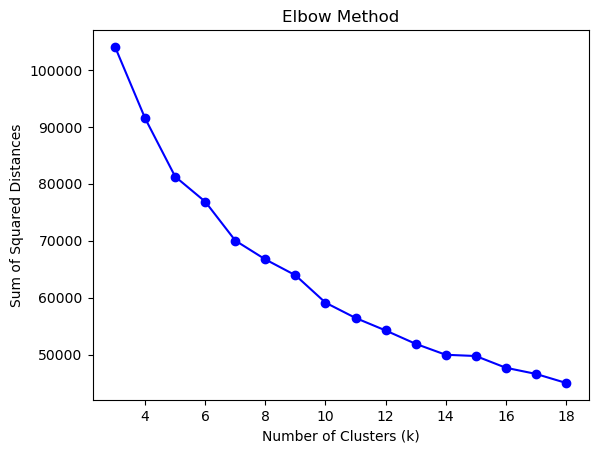

In [629]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming you have a DataFrame named playerdata with the relevant statistics
playerdata = df.loc[df.MP > 2]
playerdata_numeric = playerdata.apply(pd.to_numeric, errors='coerce')

playerdata_numeric = playerdata_numeric.fillna(0)
#playerdata = playerdata.drop(["Player"], axis=1)
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(playerdata_numeric)

# Initialize an empty list to store the sum of squared distances for each number of clusters
ssd = []

# Define the range of cluster numbers to evaluate
k_values = range(3, 19)

# Perform K-means clustering for each number of clusters and calculate the sum of squared distances
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    ssd.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, ssd, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method')
plt.show()


C:\Users\matan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\matan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\matan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\matan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

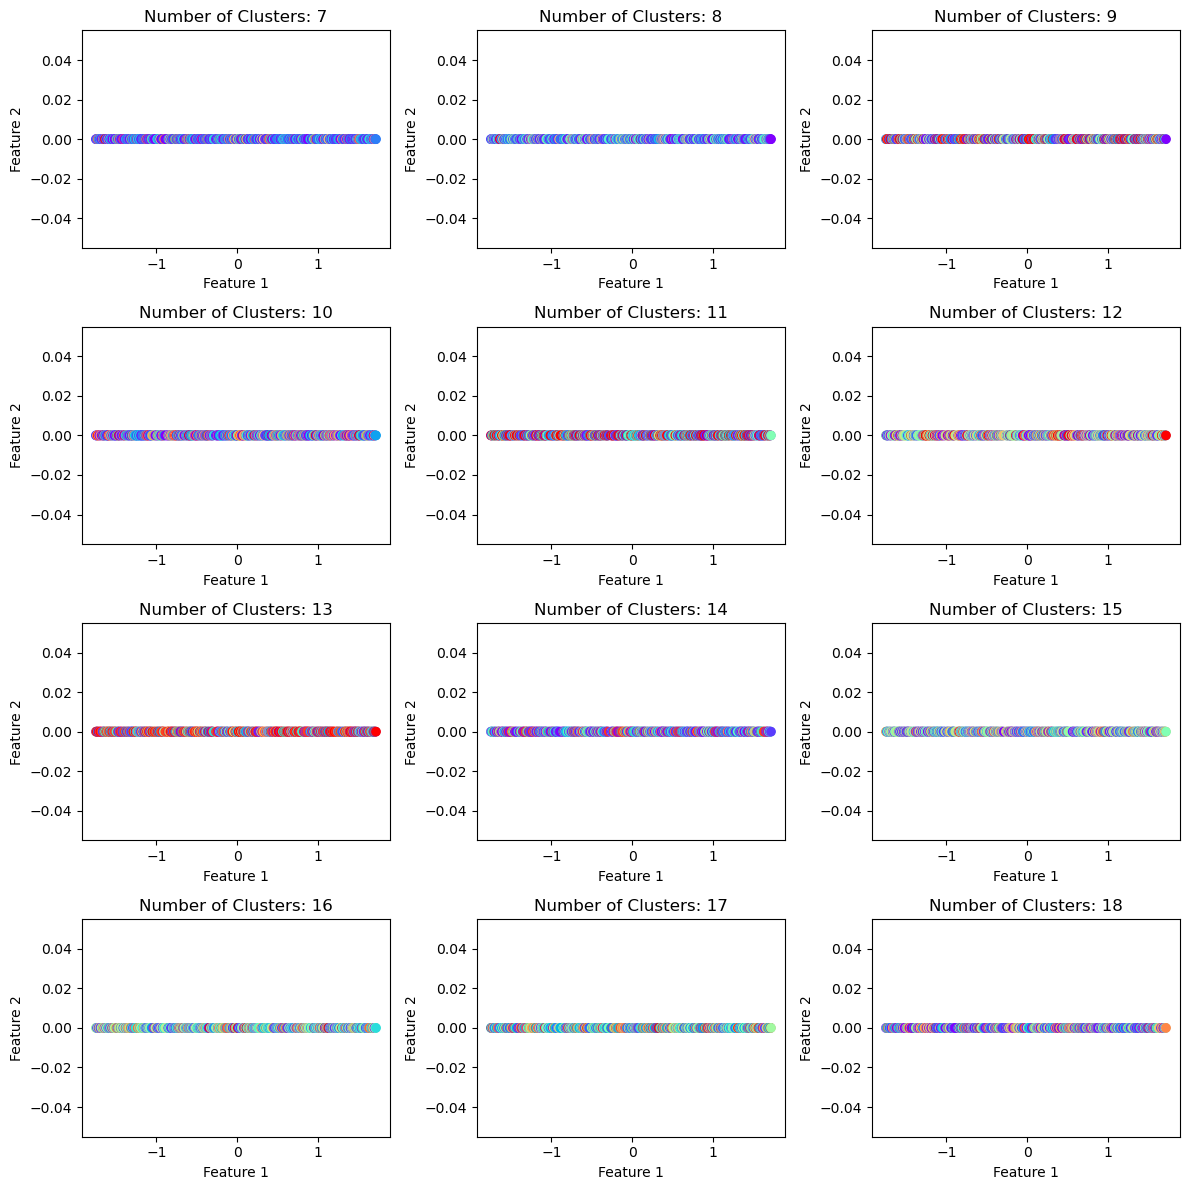

In [631]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Assuming you have a DataFrame named playerdata with the relevant statistics
playerdata = df.loc[df.MP > 2]
playerdata_numeric = playerdata.apply(pd.to_numeric, errors='coerce')

playerdata_numeric = playerdata_numeric.fillna(0)
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(playerdata_numeric)

# Define the range of cluster numbers to evaluate
k_values = range(7, 19)

# Perform K-means clustering for each number of clusters
cluster_labels = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    cluster_labels.append(labels)

# Visualize the clusters
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))
axes = axes.flatten()
for i, (k, labels) in enumerate(zip(k_values, cluster_labels)):
    ax = axes[i]
    ax.scatter(scaled_data[:, 0], scaled_data[:, 1], c=labels, cmap='rainbow')
    ax.set_title(f'Number of Clusters: {k}')
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
plt.tight_layout()
plt.show()


C:\Users\matan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\matan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\matan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\matan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

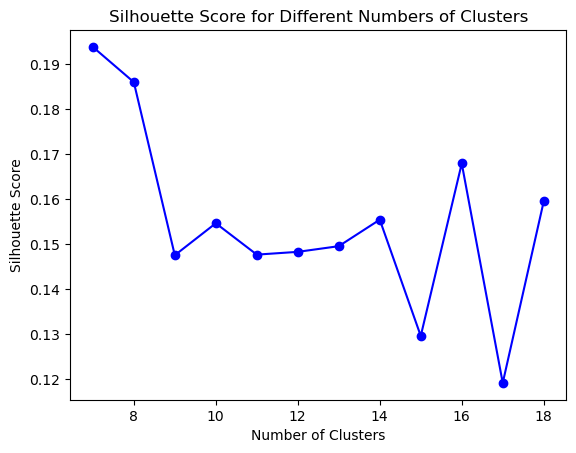

In [632]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Assuming you have a DataFrame named playerdata with the relevant statistics
playerdata = df.loc[df.MP > 2]
playerdata_numeric = playerdata.apply(pd.to_numeric, errors='coerce')

playerdata_numeric = playerdata_numeric.fillna(0)
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(playerdata_numeric)

# Initialize an empty list to store the silhouette scores for each number of clusters
silhouette_scores = []

# Define the range of cluster numbers to evaluate
k_values = range(7, 19)

# Perform K-means clustering for each number of clusters and calculate the silhouette score
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    silhouette_scores.append(silhouette_score(scaled_data, labels))

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.show()


In [643]:
import pandas as pd
from sklearn.cluster import KMeans

# Assuming you have a DataFrame named playerdata with player names and relevant statistics
playerdata = df.loc[df.Min > 900]
player_names = playerdata[['Player', "Pos"]]
playerdata_without_names = playerdata.drop(['Player', 'Pos'], axis=1)
playerdata_numeric = playerdata_without_names.apply(pd.to_numeric, errors='coerce')

playerdata_numeric = playerdata_numeric.fillna(0)
# Extract the player names column


# Remove the player names column from the dataframe


# Perform K-means clustering with 11 clusters
kmeans = KMeans(n_clusters=11, random_state=42)
kmeans.fit(playerdata_numeric)

# Get the cluster labels for each player
cluster_labels = kmeans.labels_

# Initialize a dictionary to store players in each cluster
clusters = {i: [] for i in range(11)}

# Assign players to their respective clusters
for player, pos, label in zip(player_names["Player"], player_names["Pos"], cluster_labels):
    clusters[label].append(player)
    clusters[label].append(pos)

# Print players in each cluster
for cluster, players in clusters.items():
    print(f"Cluster {cluster + 1}: {players}")


C:\Users\matan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\matan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Cluster 1: ['Thiago Almada', 'MF', 'Ethan Bartlow', 'DF', 'DeJuan Jones', 'DF', 'Brooks Lennon', 'DF', 'Nicolás Lodeiro', 'MF', 'Aidan Morris', 'MF', 'João Paulo Mior', 'MF', 'Daniel Pereira', 'MF', 'Matt Polster', 'MF', 'Albert Rusnák', 'MF', 'James Sands', 'MF']
Cluster 2: ['José Andrés Martínez', 'MF', 'Braian Cufré', 'DF', 'Hassani Dotson', 'MF', 'Franco Escobar', 'DF', 'Evander', 'MF', 'Marco Farfan', 'DF', 'Gastón Giménez', 'MF', 'Carlos Gruezo', 'MF', 'Nick Hagglund', 'DF', 'Kyle Hiebert', 'DF', 'Derrick Jones', 'MF', 'Kemar Lawrence', 'DF', 'Olivier Mbaizo', 'DF', 'Miguel Navarro', 'DF', 'John Nelson', 'DF', 'Jake Nerwinski', 'DF', 'Obinna Nwobodo', 'MF', 'Tim Parker', 'DF', 'Donovan Pines', 'DF', 'Ilie Sánchez', 'MF', 'Brandon Servania', 'MF', 'Arnaud Souquet', 'DF', 'Daniel Steres', 'DF', 'Wil Trapp', 'MF', 'Pedro Vite', 'FW', 'Ashley Westwood', 'MF']
Cluster 3: ['Lalas Abubakar', 'DF', 'César Araujo', 'MF', 'Artur', 'MF', 'Álvaro Barreal', 'DF', 'Michael Boxall', 'DF', 'Nath

In [647]:
df.loc[df.Pos == "GK"]

,Unnamed: 0,Player,Nation,Pos,Squad,Age,Born,MP,Starts,Min,...,Int.1,TklW.1,PKwon,PKcon,OG,Recov,Won,Lost.1,Won%,Matches.9
36,55,Luis Barraza,us USA,GK,NYCFC,26-205,1996.0,14.0,14.0,1260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,64,Gavin Beavers,us USA,GK,Real Salt Lake,18-033,2005.0,3.0,2.0,225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,71,Joe Bendik,us USA,GK,Philadelphia,34-037,1989.0,3.0,2.0,238,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,76,David Bingham,us USA,GK,Portland Timbers,33-225,1989.0,4.0,4.0,360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
58,81,Andre Blake,jm JAM,GK,Philadelphia,32-192,1990.0,13.0,13.0,1112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,89,Jonathan Bond,eng ENG,GK,LA Galaxy,30-013,1993.0,8.0,8.0,654,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,99,Christopher Brady,us USA,GK,Chicago Fire,19-090,2004.0,14.0,14.0,1199,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,112,Roman Bürki,ch SUI,GK,St. Louis,32-199,1990.0,13.0,13.0,1170,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,123,Drake Callender,us USA,GK,Inter Miami,25-237,1997.0,15.0,15.0,1350,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,139,Roman Celentano,us USA,GK,FC Cincinnati,22-260,2000.0,15.0,15.0,1350,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [650]:
df.loc[df.Min > 900].loc[df.Pos == "DF"]

,Unnamed: 0,Player,Nation,Pos,Squad,Age,Born,MP,Starts,Min,...,Int.1,TklW.1,PKwon,PKcon,OG,Recov,Won,Lost.1,Won%,Matches.9
0,1,Lalas Abubakar,gh GHA,DF,Colorado Rapids,28-158,1994.0,16.0,16.0,1293,...,23.0,7.0,0.0,0.0,0.0,57.0,22.0,21.0,51.2,Matches
37,56,Álvaro Barreal,ar ARG,DF,FC Cincinnati,22-288,2000.0,15.0,15.0,1294,...,20.0,26.0,0.0,0.0,0.0,90.0,5.0,8.0,38.5,Matches
40,59,Ethan Bartlow,us USA,DF,Dynamo FC,23-119,2000.0,14.0,14.0,1260,...,8.0,3.0,0.0,1.0,0.0,60.0,22.0,24.0,47.8,Matches
57,80,Tristan Blackmon,us USA,DF,Vancouver,26-293,1996.0,13.0,13.0,1125,...,19.0,5.0,0.0,0.0,1.0,61.0,29.0,17.0,63.0,Matches
68,96,Michael Boxall,nz NZL,DF,Minnesota Utd,34-287,1988.0,14.0,14.0,1260,...,28.0,11.0,0.0,0.0,0.0,80.0,21.0,6.0,77.8,Matches
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,700,Kai Wagner,de GER,DF,Philadelphia,26-106,1997.0,12.0,12.0,1079,...,20.0,15.0,0.0,0.0,0.0,95.0,10.0,4.0,71.4,Matches
520,705,Joel Waterman,ca CAN,DF,CF Montréal,27-128,1996.0,12.0,12.0,1035,...,9.0,9.0,0.0,0.0,1.0,89.0,7.0,14.0,33.3,Matches
528,714,Danny Wilson,sct SCO,DF,Colorado Rapids,31-156,1991.0,15.0,14.0,1255,...,10.0,6.0,0.0,1.0,0.0,60.0,28.0,22.0,56.0,Matches
535,724,DeAndre Yedlin,us USA,DF,Inter Miami,29-327,1993.0,14.0,13.0,1179,...,15.0,11.0,0.0,0.0,0.0,80.0,13.0,11.0,54.2,Matches
